In [1]:
from data_loader import load_data
from plot_utils import show_transform_plot
from functools import partial
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
train = load_data()

In [3]:
col_dtypes = train.dtypes
num_feats = col_dtypes[col_dtypes != 'object'].axes[0].tolist()
cat_feats = col_dtypes[col_dtypes == 'object'].axes[0].tolist()

In [48]:
print(num_feats)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


## Correlation analysis

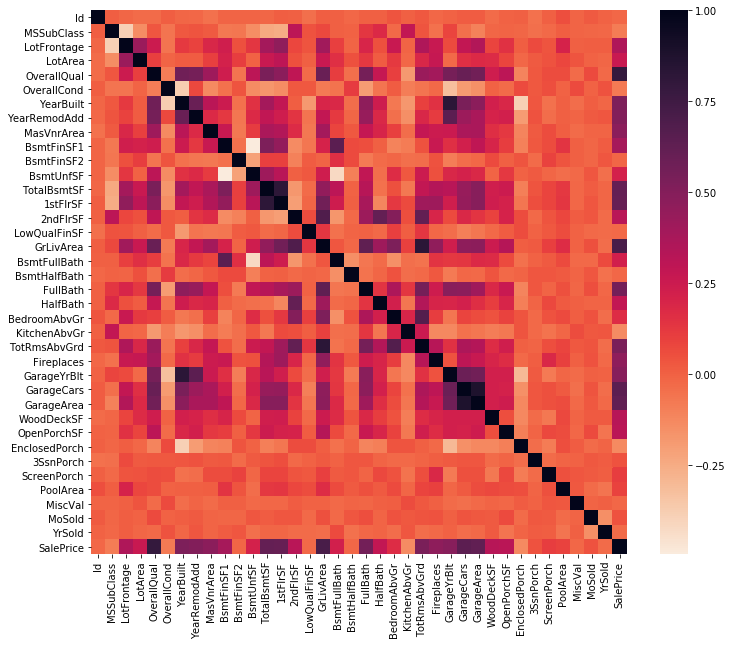

In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(method='pearson'), cmap=sns.cm.rocket_r)

Observations (based only on heatmap of correlations):  
1. GarageYrBlt are strong correlated with YearBuilt -> house in most cases was originally built with garage.  
- GarageYrBlt with cars and area -> some trend on garage size to be bigger 
- GarageArea with OverallQual -> the better quality, the bigger, newer garages
- OverallQual correlations -> bigger, newer houses
- TotalBasementSF correlation with 1stFlrSF -> 1st floor almost same like basement
- Bigger BsmtFinSF[1 or 2] gives lower BsmtUnfSF
- MoSold hasn't any significant correlation with all variables 

# Sale Price analysis

In [5]:
# create variable for convenience
price = train['SalePrice']
# auxiliary methods in plot_utils files
# higher order function for convenience
show_log_transform = partial(show_transform_plot, trans_fun=np.log, fit_dist=stats.norm, metrics=[stats.skew, stats.kurtosis])

### Price description

In [6]:
price.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Pirice distribution

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


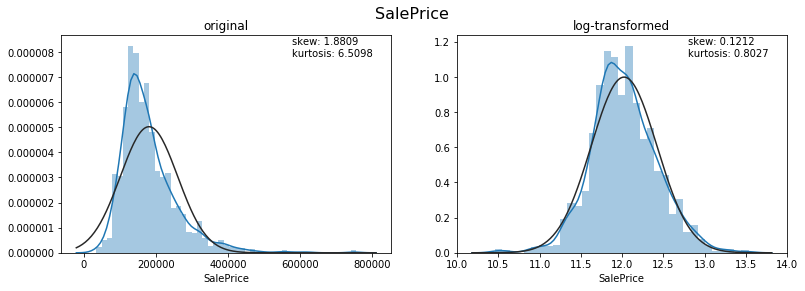

In [7]:
show_log_transform(price)

In [8]:
zscored_price = stats.zscore(np.log(price))
quntil_bound =3.5
np.logical_or(zscored_price>quntil_bound, zscored_price<-quntil_bound).sum()

7

1. SalePrice is right skewed and its distribution has big kurtosis. For the sake of SalePrice being from Gaussian we can apply transformation
    - Log transformation reduce skewness and kurtosis
    - Boxcox transformation works also well, however results are similar to log-transform
- We can assume that in dataset some outlier occured (7 outliers if taking 3.5 quantile as outlier boundary)
    - deleting outlier values will be considered, because we have to keep in mind that in test set some outliers may appear

# Other countinuous variables analysis

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


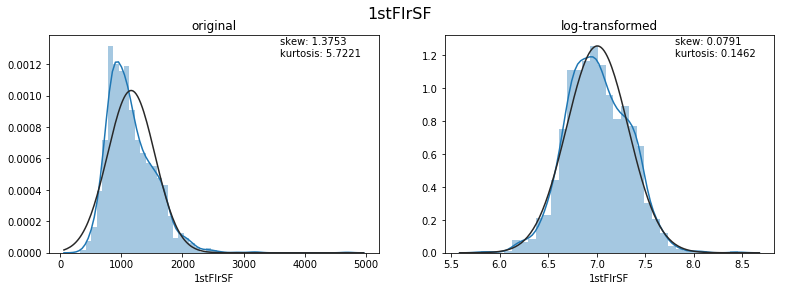

In [9]:
show_log_transform(train['1stFlrSF'])

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


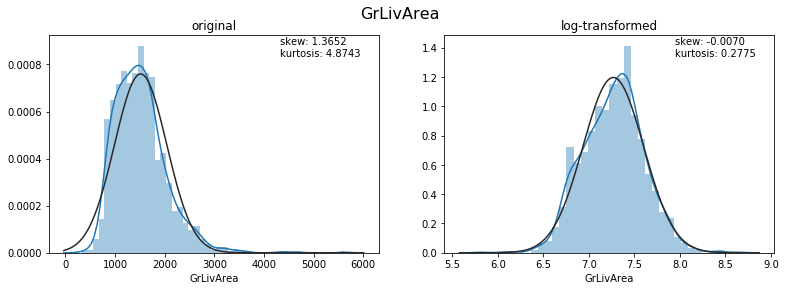

In [10]:
show_log_transform(train['GrLivArea'])

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


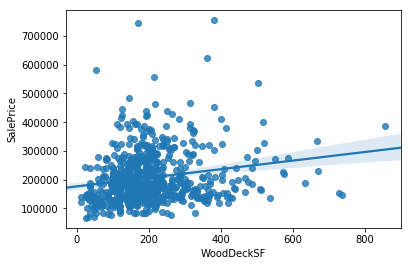

In [11]:
is_wood_deck = train['WoodDeckSF']>0
sns.regplot(train[is_wood_deck]['WoodDeckSF'], price[is_wood_deck])

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


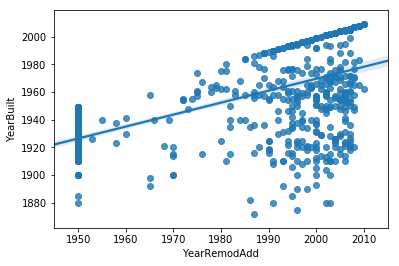

In [12]:
is_remode_add = train['YearRemodAdd']!=train['YearBuilt']
sns.regplot(train[is_remode_add]['YearRemodAdd'], train[is_remode_add]['YearBuilt'])

1. 1stFlr and GrLivArea are both right skewed: apply log transformation gives good results at shape of distribution. BoxCox transformation is almost same like log-transform, so we could safely apply both
- WoodDeckSF is correlated with SalePrice or other square footages but not so well
- Due to heatmap informations about porch aren't correlated to each other
- YearRemodAdd starting in 1950 and is same as year built if no remodel is added; most remodel was added after 2000 and in 1950. Distribution looks messy and doesn't fit well neither YearBuilt nor SalePrice
    - instead of year we can apply indicator

### 2ndFlrSF 

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


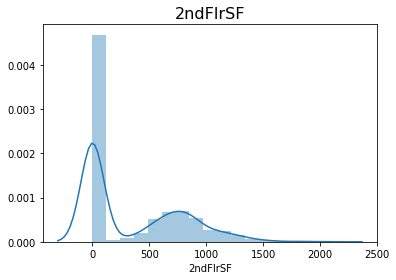

In [13]:
plt.title('2ndFlrSF', fontsize=16)
sns.distplot(train['2ndFlrSF'])

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'nonzero 2ndFlrSF correlation with 1stFlrSF')

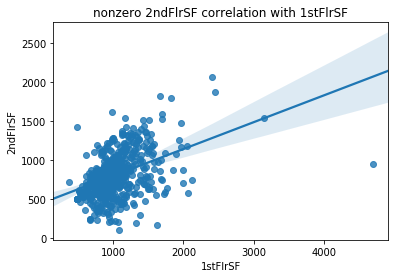

In [14]:
nonzero_2ndFlrSF = train['2ndFlrSF']>0
sns.regplot(train[nonzero_2ndFlrSF]['1stFlrSF'], train[nonzero_2ndFlrSF]['2ndFlrSF'])
plt.title('nonzero 2ndFlrSF correlation with 1stFlrSF')

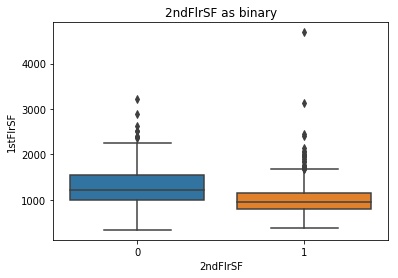

In [15]:
ndFlrSF_indicator = train['2ndFlrSF'].apply(lambda x:  1 if x>0 else 0)
plt.title('2ndFlrSF as binary')
sns.boxplot(ndFlrSF_indicator, train['1stFlrSF'])

1. 2ndFlrSF is mostly 0 and normally distributed when greater than 0. Correlation with 1stFlrSF means that house's square footage is equal (aproximately) at each floor
    - applying indicator (whether 2ndFlr exists in the house) might be reasonable
- Houses without 2nd floor are rather bigger than houses with 2nd floor

### Garage

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


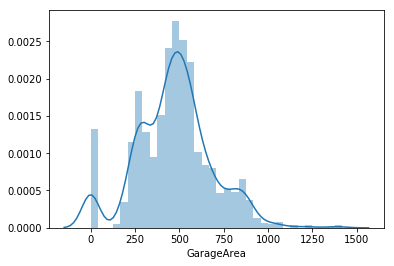

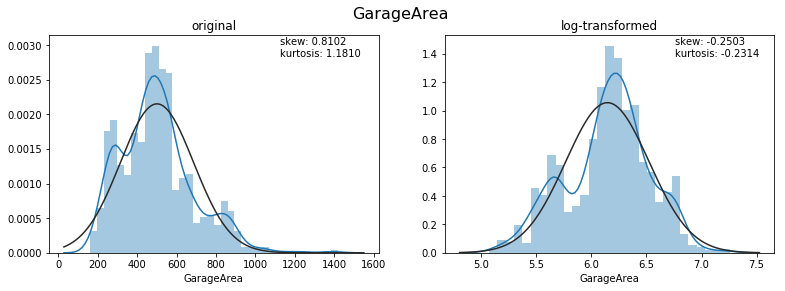

In [16]:
sns.distplot(train['GarageArea'])
show_log_transform(train[train['GarageArea']>0]['GarageArea'])

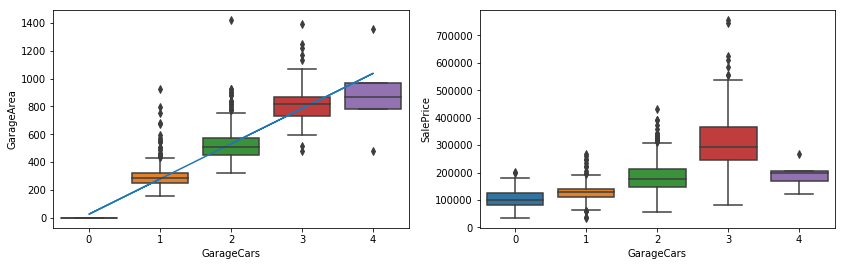

In [17]:
slope, intercept, _, _, _ = stats.linregress(train['GarageCars'],train['GarageArea'])
line = lambda x: slope*x+intercept
_, ax  = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot('GarageCars', 'GarageArea', data=train, ax=ax[0])
ax[0].plot(train['GarageCars'],line(train['GarageCars']))
sns.boxplot('GarageCars', 'SalePrice', data=train, ax=ax[1])

In [18]:
print('4-cars-garage houses num: ', (train['GarageCars']==4).sum())

4-cars-garage houses num:  5


c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


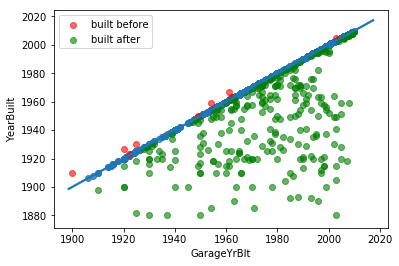

In [19]:
garage_blt_with_house = train['GarageYrBlt'] == train['YearBuilt']
garage_blt_before_house = train['GarageYrBlt'] < train['YearBuilt']
garage_blt_after_house = train['GarageYrBlt'] > train['YearBuilt']
different_garage_YrBlt = garage_blt_before_house | garage_blt_after_house
ax = plt.subplot(111)
eq =sns.regplot(train[garage_blt_with_house]['GarageYrBlt'], train[garage_blt_with_house]['YearBuilt'], ax=ax)
before = ax.scatter(train[garage_blt_before_house]['GarageYrBlt'], train[garage_blt_before_house]['YearBuilt'], color='red', alpha=.6)
after = ax.scatter(train[garage_blt_after_house]['GarageYrBlt'], train[garage_blt_after_house]['YearBuilt'], color='green', alpha=.6)
ax.legend((before, after), ('built before', 'built after'))

In [20]:
print("Ratio of garages built same time with house: ", garage_blt_with_house.sum()/train.shape[0])
print("Number of garages built before house: ", (train['GarageYrBlt']<train['YearBuilt']).sum())
print("Number of garages built after house: ", (train['GarageYrBlt']>train['YearBuilt']).sum())

Ratio of garages built same time with house:  0.7458904109589041
Number of garages built before house:  9
Number of garages built after house:  281


1. GarageArea distributon is messy and in order to some peaks isn't good aproximation of normal distribution. In addition to this we see that there are many examples without garage (area = 0). Any transformatioan (log, boxcox) dosen't give us shape improvement
- GarageCars are strongly correlated with GarageArea (multicolinearity), except the case there 4 cars garage, where regline doesn't fit so well as in the less car garages
    - to tackle undesirebale shape of GarageArea distribution we could use only garage cars in the model (and it seems reasonable, since the main function of garage is to park cars there and number of cars determine it's atractiveness)
- Apart from fact that 4-cars garages doesn't fit to overall area regline, also their house's price is sprisingly lower then 3 or 2 cars garages houses. However there are only 5 examples of such houses
    - we can ignore facts about 4-cars-garage houses being something like outlier in model
- Almost 75% of garages were built along with house. Most of garages have been built before or after house year built with difference only 1-3 years, so we make assumption that garage year built is equal to house year built. Hence GarageYrBlt is redundant to YearBuilt
    - we can drop this feature for model

### Basement

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


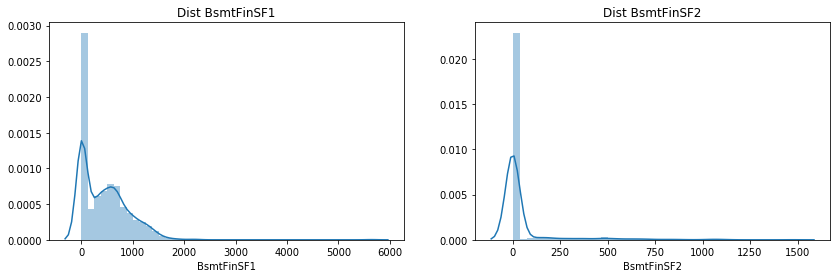

In [21]:
_, ax = plt.subplots(1, 2, figsize=(14,4))
ax[0].set_title('Dist BsmtFinSF1')
ax[1].set_title('Dist BsmtFinSF2')
sns.distplot(train['BsmtFinSF1'], ax = ax[0])
sns.distplot(train['BsmtFinSF2'], ax = ax[1])

In [22]:
print('FinSF2 when FinSF is 0: ',train['BsmtFinSF2'].where(train['BsmtFinSF1']==0).unique())

FinSF2 when FinSF is 0:  [nan  0.]


c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


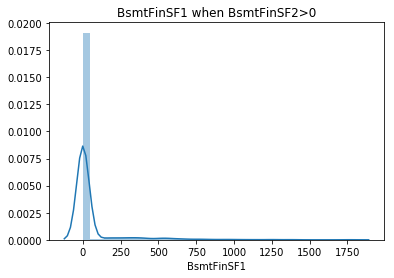

In [23]:
sns.distplot(train['BsmtFinSF1'].where(train['BsmtFinSF2']>0).fillna(0))
plt.title('BsmtFinSF1 when BsmtFinSF2>0')
plt.show()

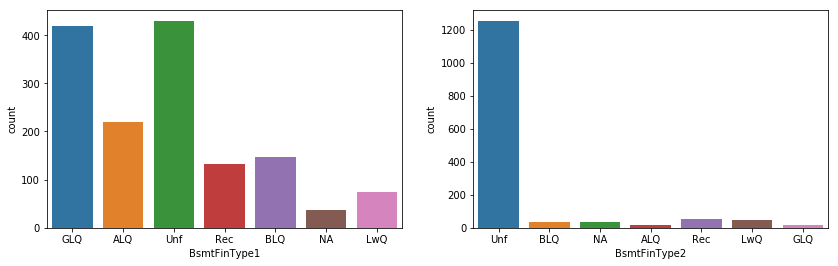

In [24]:
_,ax = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(train['BsmtFinType1'].fillna('NA'), ax=ax[0])
sns.countplot(train['BsmtFinType2'].fillna('NA'), ax=ax[1])

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


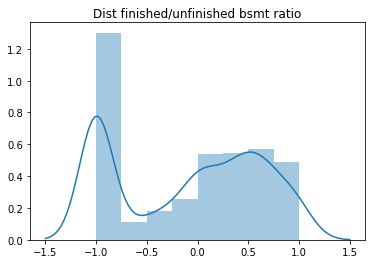

In [25]:
bmst_fin = train['BsmtFinSF1'] + train['BsmtFinSF2']
bmst_fin_unfin_ratio = ((bmst_fin - train['BsmtUnfSF'])/train['TotalBsmtSF']).fillna(0)
sns.distplot(bmst_fin_unfin_ratio)
plt.title('Dist finished/unfinished bsmt ratio')
plt.show()

1. BsmtFinSF2 is mostly equal to 0 and hasn't any significant correlation with SalePrice and any other feature (based on heatmap)
2. When there is no first type basement, hence there is no second type basement, but when bsmt type 2 exists some positive SF of bsmt type 1 (however most is 0)
3. Most of cases have totally unfinished basement or partially finished/unfinished. Basement of type 2 is almost always unfinshed/low-quality/Average Rec Room, so most of time we have basements not prepared for living

## Sum of all areas

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


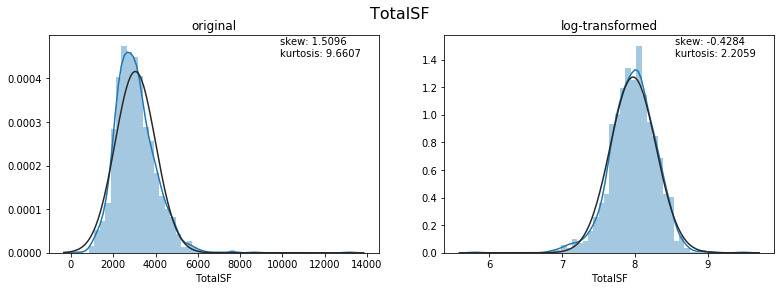

In [26]:
TotalSaleSF = pd.Series(train['GrLivArea']+train['TotalBsmtSF']+train['GarageArea'], name='TotalSF')
show_log_transform(TotalSaleSF)

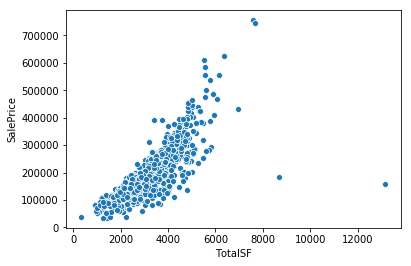

In [27]:
all_SF = TotalSaleSF
sns.scatterplot(all_SF, price)

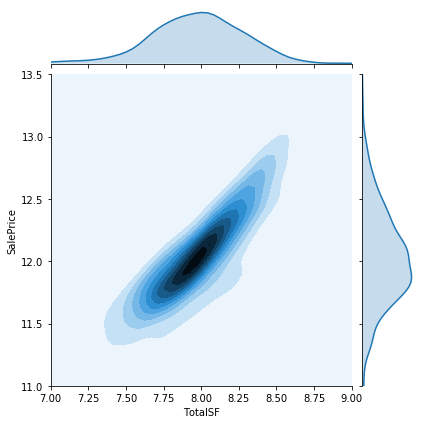

In [28]:
sns.jointplot(np.log(TotalSaleSF), np.log(price), kind='kde', xlim=(7, 9), ylim=(11,13.5))

1. Total house SF means all area which belongs to house. However even, when transformation is applied, data has still posisitive kurtosis (undesirable high) and using such structural variable must be considered via model selection
    - total area may be check by replacing all areas, nevertheless it cause vanishing of many essential informations
    - using total alongside with other SFs will introduce feature with structural multicolinearity into model

## Other features

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


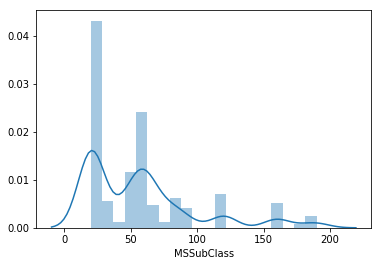

In [29]:
sns.distplot(train['MSSubClass'])

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


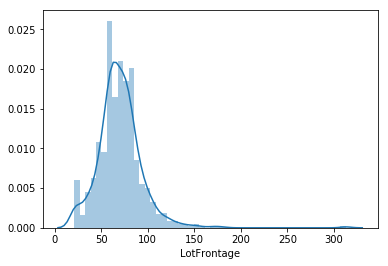

In [30]:
sns.distplot(train['LotFrontage'].dropna())

## OverallQual and OverallCond

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


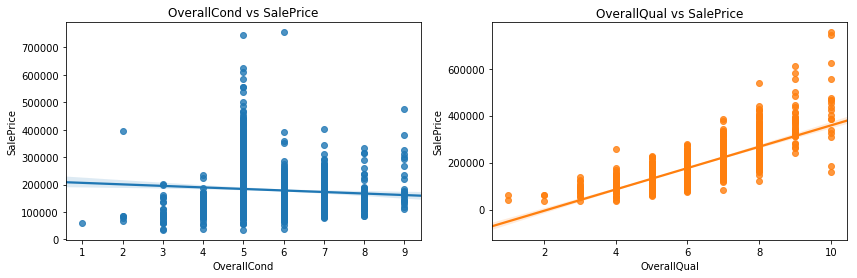

In [31]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.regplot(train['OverallCond'], price, ax=ax[0])
sns.regplot(train['OverallQual'], price, ax=ax[1])
ax[0].set_title('OverallCond vs SalePrice')
ax[1].set_title('OverallQual vs SalePrice')
plt.show()

1. OverallCond hasn't any significant correation. SalePrice are more spread when increasing condidtion value, hence for SalePrice OverallConf doesn't give much information
- OverallQual is very strongly correlated with price 

# Other correlations (multicolinearity)

### LotFrontage vs. LotArea

In [32]:
non_null_frontage_idx = train['LotFrontage'].notnull()
print('Raw values corr: ', stats.pearsonr(train[non_null_frontage_idx]['LotFrontage'], train[non_null_frontage_idx]['LotArea']))
print('Log trans values corr: ', stats.pearsonr(np.log(train[non_null_frontage_idx]['LotFrontage']), np.log(train[non_null_frontage_idx]['LotArea'])))

Raw values corr:  (0.42609501877180794, 3.697416826266103e-54)
Log trans values corr:  (0.745550090492558, 1.537012138757967e-213)


c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


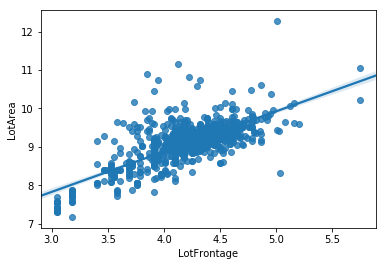

In [33]:
sns.regplot(np.log(train['LotFrontage']), np.log(train['LotArea']))

1. Taking logarithm of this two variables boosting correlation and deacreasing p-value(good)
2. The existence of correlation among this variables gives us abiblity to:
    - imput missing data in LotFrontage (e.g. by regression) or delete LotFrontage and rely only on LotArea feature (LotArea are more correlated to target than LotFrontage)  
    - We can replace this two variables by their sum
4. Some values seems to be outliers, that are: LotFrontage>300 and LotArea>200000 (in original data)

### 1stFlrSF vs TotalBsmtSF

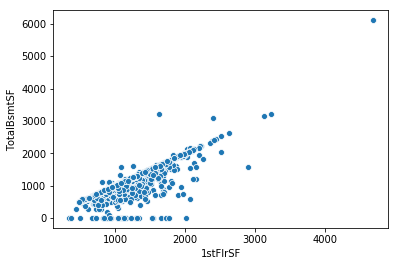

In [34]:
sns.scatterplot(train['1stFlrSF'], train['TotalBsmtSF'])

1. 1stFlrSF is strongly correlated with TotalBsmtSF, however there are houses without basement
    - we can replace feature TotalBsmtSF with binary feature indicating whether house containing basement or not (see below), this replacement reduce information about basementSF, but since it's correlated with 1stFlrSF (and other BsmtSF) we won't loose much information

# Numerical to categorical

## YearBuilt

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


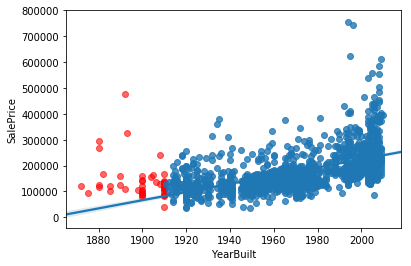

In [35]:
above_yr = train['YearBuilt']>1910
ax = plt.subplot(111)
ax.scatter(train[~above_yr]['YearBuilt'], train[~above_yr]['SalePrice'], color='red', alpha=.6)
sns.regplot(train[above_yr]['YearBuilt'], train[above_yr]['SalePrice'], ax=ax)

In [36]:
#Example of such discretization
YearBuilt_discretized = pd.qcut(train['YearBuilt'], q=4, labels=['retro', 'old', 'medium', 'new'], retbins=True)
# YearBuilt_discretized = pd.qcut(train['YearBuilt'], 7, retbins=True)
YearBuilt_discretized[1]

array([1872., 1954., 1973., 2000., 2010.])

Text(0.5,1,'Discretized with SalePrice correlation')

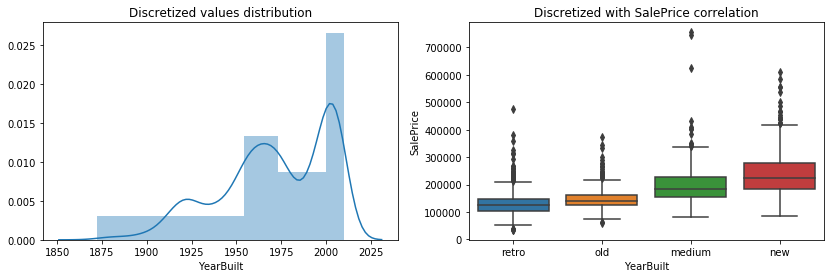

In [37]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(train['YearBuilt'], bins=YearBuilt_discretized[1], ax=ax[0])
ax[0].set_title('Discretized values distribution')
sns.boxplot(YearBuilt_discretized[0], price, ax=ax[1])
ax[1].set_title('Discretized with SalePrice correlation')

1. Since there are many examples of old houses that are not exactly as cheap as regline says, so we can discretize values of YearBuilt. Feasible division will be set during model selection, however it's seems resonable to divide due to regression line (especially very old houses wich are more expensive than supposed to be)  
    - ad-hoc solution (by observing regplot) to division seems to work well, but for each category (escpecially for the oldest houses) there is too much outliers
    - using qcut (cut continuous by quantilles) we got also good division (4-6 quantilles work the best), however it's also suffers from too much outliers in older houses

### TotalBsmtSF

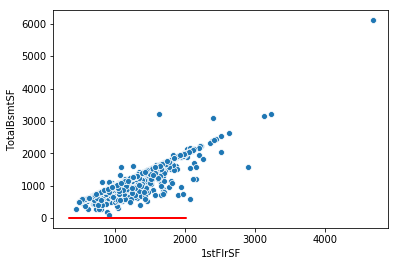

In [38]:
nonzero_TotalBsmtSF_idx = train['TotalBsmtSF']>0
sns.scatterplot(train[nonzero_TotalBsmtSF_idx]['1stFlrSF'], train[nonzero_TotalBsmtSF_idx]['TotalBsmtSF'])
plt.plot(train[~nonzero_TotalBsmtSF_idx]['1stFlrSF'], train[~nonzero_TotalBsmtSF_idx]['TotalBsmtSF'], color='red')

In [39]:
TotalBsmtSF_disc = train['TotalBsmtSF'].apply(lambda x: 0 if x==0 else 1)

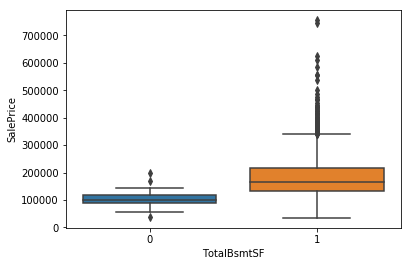

In [40]:
sns.boxplot(TotalBsmtSF_disc, price)

1. Basement are 0 in many cases (red dots in scatter; when there is no basement) and strongly correlated with 1stFlrSF applying indicator looks working well
- In plot above looks like lower-price houses haven't basement, and price in basement-houses is much spread, however we could rely on correlation with SalePrice

In [41]:
for feature in num_feats:
    print(feature, '--------------------------------------------------')
    print('skew', stats.skew(train[feature]))    
    print('kurtosis', stats.kurtosis(train[feature]),'\n\n')

Id --------------------------------------------------
skew 0.0
kurtosis -1.2000011259153338 


MSSubClass --------------------------------------------------
skew 1.4062101115313512
kurtosis 1.5706747728574895 


LotFrontage --------------------------------------------------
skew nan
kurtosis nan 


LotArea --------------------------------------------------
skew 12.195142125084478
kurtosis 202.5437927513529 


OverallQual --------------------------------------------------
skew 0.2167209765258641
kurtosis 0.091856548449611 


OverallCond --------------------------------------------------
skew 0.6923552135520978
kurtosis 1.0985212295913955 


YearBuilt --------------------------------------------------
skew -0.612830724202899
kurtosis -0.44215484565294716 


YearRemodAdd --------------------------------------------------
skew -0.5030444967597948
kurtosis -1.2719991404772555 


MasVnrArea --------------------------------------------------
skew nan
kurtosis nan 


BsmtFinSF1 ---------------

In [42]:
(train['TotRmsAbvGrd'] == train['KitchenAbvGr']+train['BedroomAbvGr']).where(lambda x: x).dropna()

121     1.0
165     1.0
344     1.0
490     1.0
533     1.0
954     1.0
1218    1.0
1332    1.0
1432    1.0
dtype: float64

c:\users\kuba\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


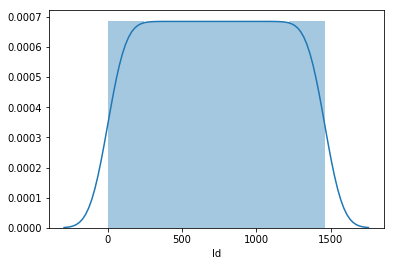

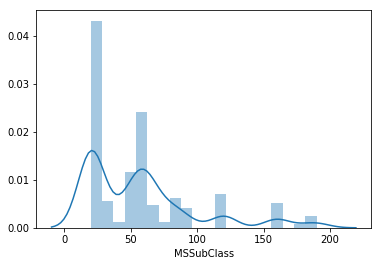

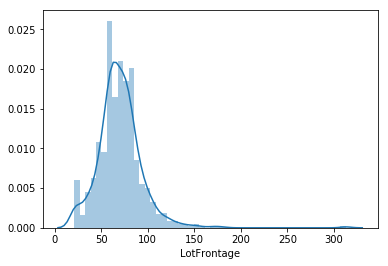

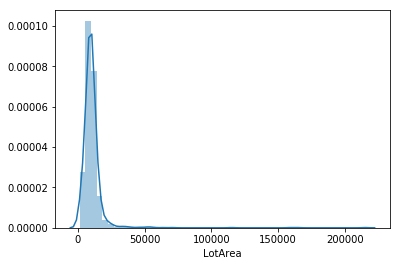

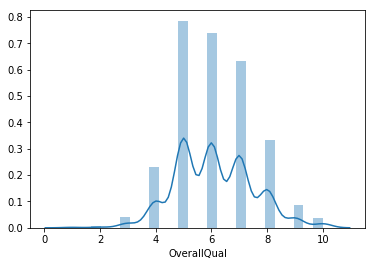

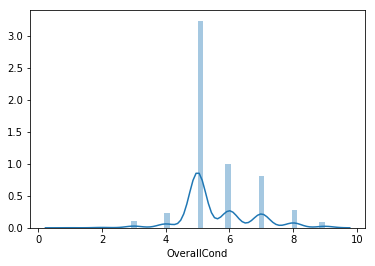

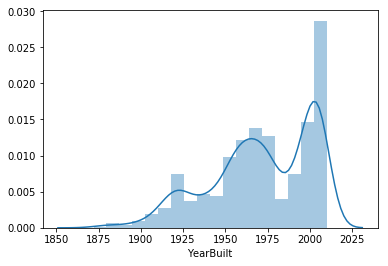

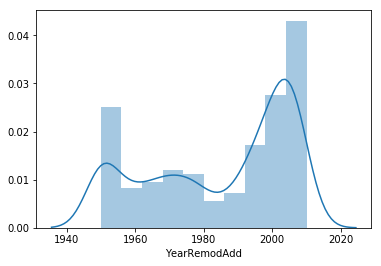

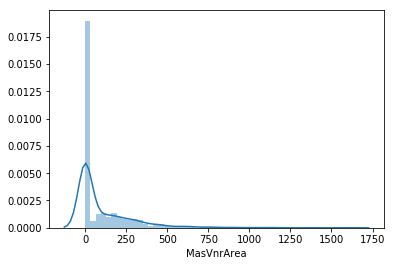

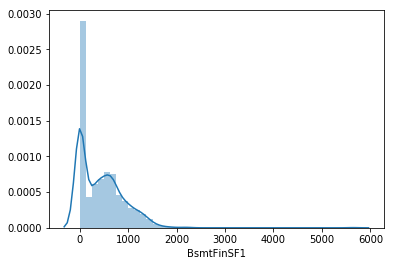

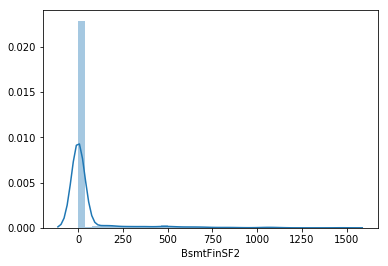

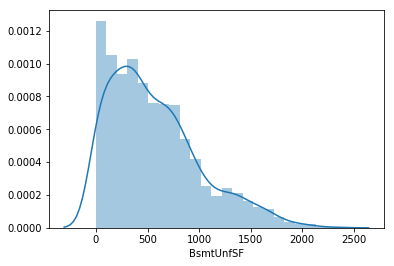

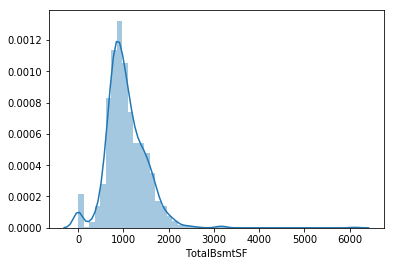

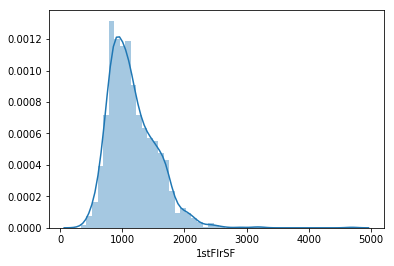

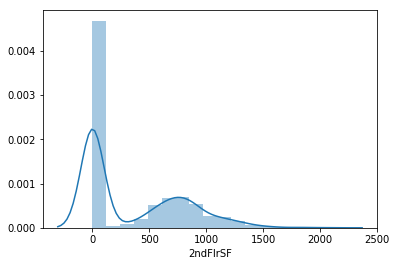

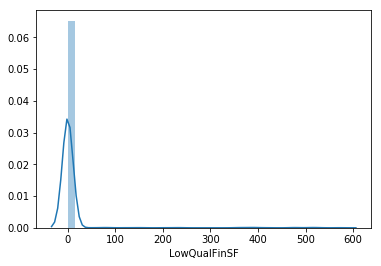

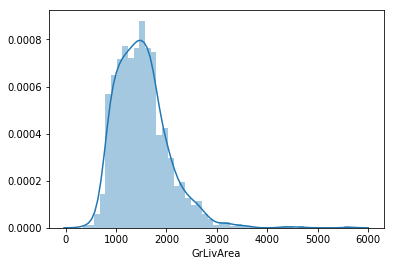

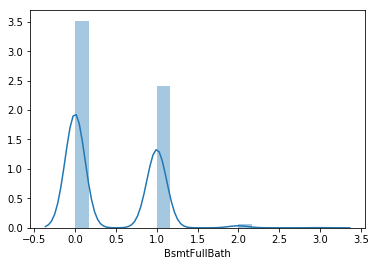

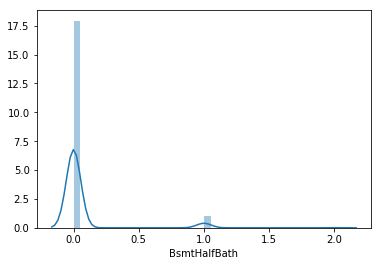

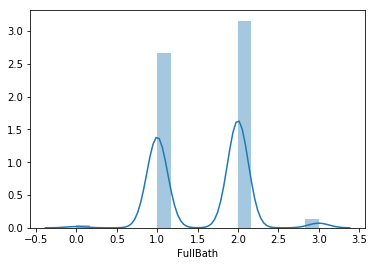

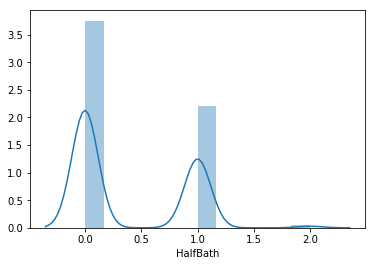

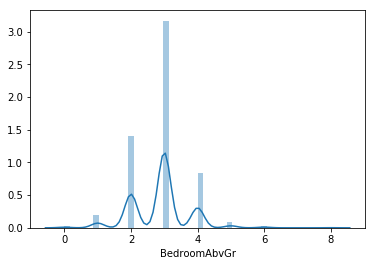

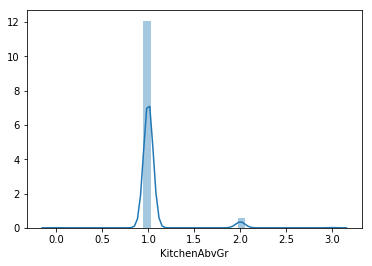

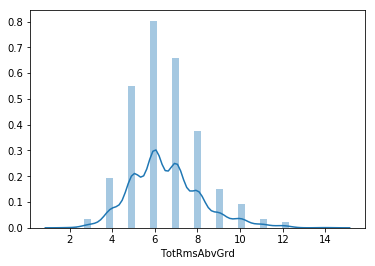

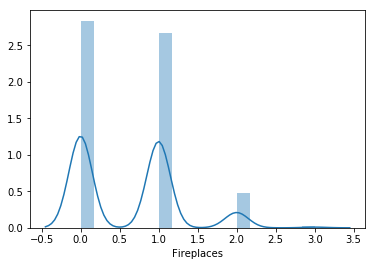

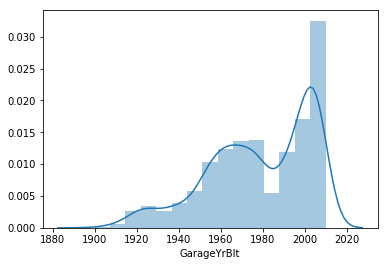

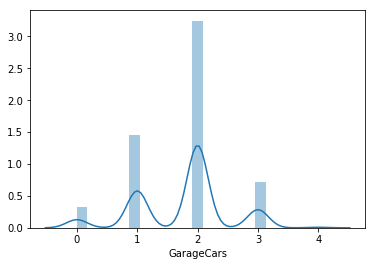

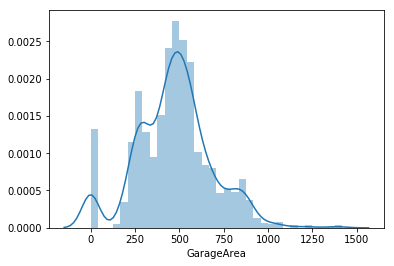

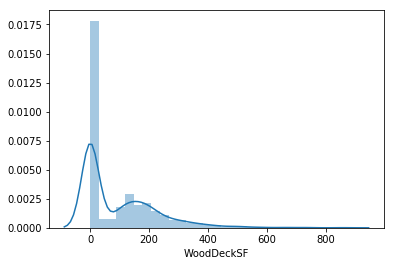

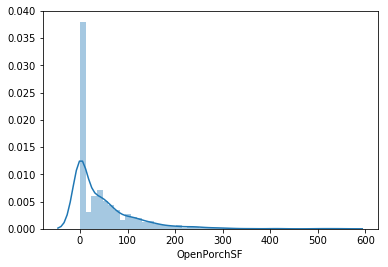

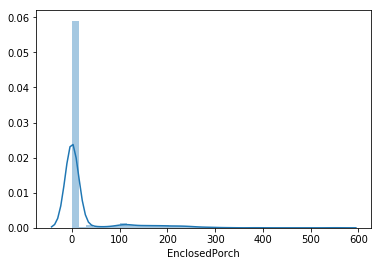

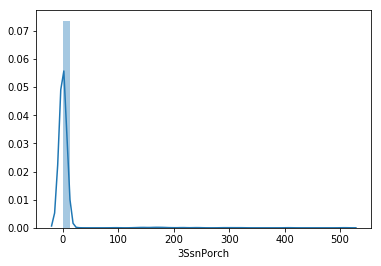

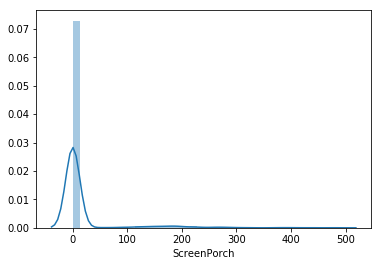

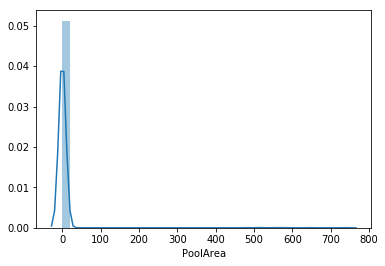

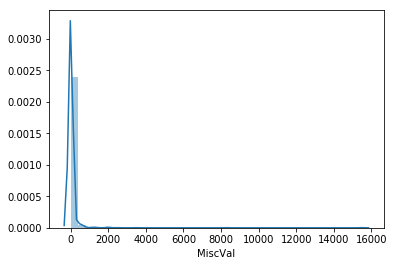

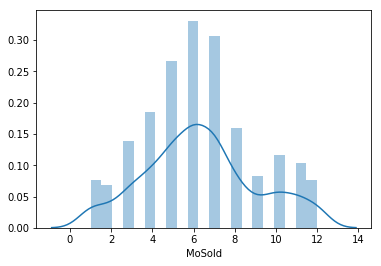

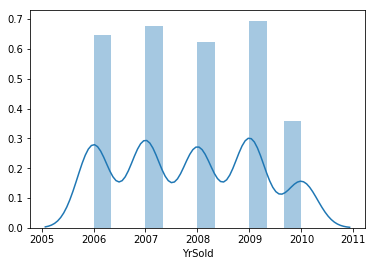

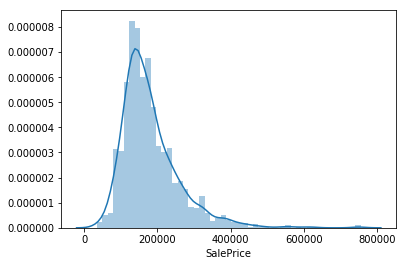

In [43]:
for f in num_feats:
    sns.distplot(train.loc[train[f].notnull(), f])
    plt.show()